<a href="https://colab.research.google.com/github/cosminnedescu/ProjectMLDL/blob/main/classifiers/iCaRL-v1_3_1-SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Avoid K80
!nvidia-smi

Mon Jul  5 09:29:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Subset, DataLoader

from PIL import Image

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from copy import copy
from copy import deepcopy

#### Cloning the Git repository

In [3]:
!rm -rf ProjectMLDL
if not os.path.isdir('/content/ProjectMLDL'):
  !git clone https://github.com/cosminnedescu/ProjectMLDL.git
  %cd /content/ProjectMLDL
  !rm -rf LICENSE README.md

Cloning into 'ProjectMLDL'...
remote: Enumerating objects: 2093, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 2093 (delta 157), reused 119 (delta 106), pack-reused 1886
Receiving objects: 100% (2093/2093), 88.53 MiB | 34.60 MiB/s, done.
Resolving deltas: 100% (1123/1123), done.
/content/ProjectMLDL


In [4]:
from data.cifar100 import CIFAR100
from model.resnet32 import resnet32
import data.utils
from model.icarl import SVM_Classifier

In [5]:
# True mean and std of Cifar100 dataset (src="https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151")
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(mean, std),
     ])

## Incremental Classifier and Representation Learning

### Defining hyperparameters according to iCarl paper

In [6]:
# Settings
DEVICE = 'cuda'
NUM_CLASSES = 100         # Total number of classes
VAL_SIZE = 0.2            # Proportion of validation set with respect to training set (between 0 and 1)

# Training
BATCH_SIZE = 128          # Batch size
LR = 1                    # Initial learning rate
                       
MOMENTUM = 0.9            # Momentum for stochastic gradient descent (SGD)
WEIGHT_DECAY = 1e-5       # Weight decay from iCaRL

RANDOM_SEED = [20,24,66]  # Random seeds defining the runs of every method
                          # Note: this should be at least 3 to have a fair benchmark

NUM_EPOCHS = 70           # Total number of training epochs
MILESTONES = [43, 63]     # Step down policy from iCaRL (MultiStepLR)
                          # Decrease the learning rate by gamma at each milestone
GAMMA = 0.2               # Gamma factor from iCaRL (1/5)

HERDING = False           # True to perform prioritized selection, False to perform random selection
CLASSIFY = True           # True to use mean-of-exemplar classifier, False to use network's output directly for classification

In [7]:
def do_group_classes(run):

  train_subset = [[] for i in range(10)]
  train_dataloader = [[] for i in range(10)]
  val_dataloader = [[] for i in range(10)]
  test_dataloader = [[] for i in range(10)]

  for i in range(10):
    train_data = CIFAR100("dataset", 
                          train=True, 
                          transform=train_transform, 
                          download=(run+i==0),
                          random_state=RANDOM_SEED[run])
    test_data = CIFAR100("dataset", 
                         train=False, 
                         transform=test_transform, 
                         download=False,
                         random_state=RANDOM_SEED[run])
    
    train_data.set_index_map(train_data.splits[i])
    test_data.set_index_map([test_data.splits[j] for j in range(0, i+1)])
    
    train_indices, val_indices = train_data.train_val_split(VAL_SIZE, RANDOM_SEED[run])
    
    train_subset[i] = copy(Subset(train_data, train_indices))
    val_subset = Subset(train_data, val_indices)

    tmp_dl = DataLoader(val_subset,
                       batch_size=BATCH_SIZE,
                       shuffle=True, 
                       num_workers=4,
                       drop_last=True)
    val_dataloader[i] = copy(tmp_dl)

    tmp_dl = DataLoader(test_data,
                       batch_size=BATCH_SIZE,
                       shuffle=True, 
                       num_workers=4,
                       drop_last=True)
    test_dataloader[i] = copy(tmp_dl)

  return train_dataloader, val_dataloader, test_dataloader, train_subset

### Going on with the model
This is the main iCaRL step.

This step is run 3 times with different `RANDOM_SEED`.
Here the model is instantiated, trained and tested.

Results and some statistics are then stored in the variable `logs`.

In [8]:
params = {'C': [.1, 1, 10, 100],
          'kernel': ['linear']}

In [9]:
logs = [[] for i in range(len(RANDOM_SEED))]
best_net_tot_classes = [None for i in range(len(RANDOM_SEED))]

for run in range(len(RANDOM_SEED)):
  print("#################################")
  print(f"Radom seed: {RANDOM_SEED[run]}")
  print("")

  # get data_subsets separated in incremental groups of 10 classes
  train_dl, val_dl, test_dl, train_set = do_group_classes(run)

  #create the resnet
  net = resnet32()
  
  trainer = SVM_Classifier(DEVICE,
                  net,
                  LR,
                  MOMENTUM,
                  WEIGHT_DECAY,
                  MILESTONES,
                  GAMMA,
                  train_dl,
                  val_dl,
                  test_dl,
                  BATCH_SIZE,
                  train_set,
                  train_transform,
                  test_transform,
                  params)

  #train and evaluate the model
  logs[run] = trainer.train_model(NUM_EPOCHS, HERDING, CLASSIFY)

  best_net_tot_classes[run] = deepcopy(trainer.best_net)

  print("#################################")
  print("")
  print("")

#################################
Radom seed: 20




Extracting dataset/cifar-100-python.tar.gz to dataset


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Length of exemplars set: 0
Epoch 1/70 LR: [1]
Validation accuracy on group 1/10: 0.16
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 1/10: 0.15

Epoch 3/70 LR: [1]
Validation accuracy on group 1/10: 0.17
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 1/10: 0.20
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 1/10: 0.24
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 1/10: 0.26
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 1/10: 0.27
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 1/10: 0.30
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 1/10: 0.36
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 1/10: 0.36
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 1/10: 0.43
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 1/10: 0.39

Epoch 13/70 LR: [1]
Validation accuracy on group 1/10: 0.42


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.81


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 2/10: 0.03
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 2/10: 0.07
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 2/10: 0.16
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 2/10: 0.19
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 2/10: 0.22
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 2/10: 0.25
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 2/10: 0.28
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 2/10: 0.32
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 2/10: 0.34
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 2/10: 0.34

Epoch 11/70 LR: [1]
Validation accuracy on group 2/10: 0.38
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 2/10: 0.35

Epoch 13/70 LR: [1]
Validation accuracy on group 2/10: 0.41
Best model updated

Epoch 1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.68


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 3/10: 0.06
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 3/10: 0.12
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 3/10: 0.23
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 3/10: 0.20

Epoch 5/70 LR: [1]
Validation accuracy on group 3/10: 0.24
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 3/10: 0.26
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 3/10: 0.34
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 3/10: 0.32

Epoch 9/70 LR: [1]
Validation accuracy on group 3/10: 0.35
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 3/10: 0.34

Epoch 11/70 LR: [1]
Validation accuracy on group 3/10: 0.38
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 3/10: 0.37

Epoch 13/70 LR: [1]
Validation accuracy on group 3/10: 0.40
Best model updated

Epoch 14/70 LR: [1]
Validation accuracy on gr

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.63


Length of exemplars set: 1980


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 4/10: 0.11
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 4/10: 0.14
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 4/10: 0.19
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 4/10: 0.21
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 4/10: 0.24
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 4/10: 0.24
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 4/10: 0.30
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 4/10: 0.30

Epoch 9/70 LR: [1]
Validation accuracy on group 4/10: 0.33
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 4/10: 0.32

Epoch 11/70 LR: [1]
Validation accuracy on group 4/10: 0.33

Epoch 12/70 LR: [1]
Validation accuracy on group 4/10: 0.34
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy on group 4/10: 0.40
Best model updated

Epoch 14/70 LR: [1]
Valida

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.55


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 5/10: 0.14
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 5/10: 0.26
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 5/10: 0.29
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 5/10: 0.32
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 5/10: 0.31

Epoch 6/70 LR: [1]
Validation accuracy on group 5/10: 0.34
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 5/10: 0.35
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 5/10: 0.37
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 5/10: 0.42
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 5/10: 0.36

Epoch 11/70 LR: [1]
Validation accuracy on group 5/10: 0.42

Epoch 12/70 LR: [1]
Validation accuracy on group 5/10: 0.42

Epoch 13/70 LR: [1]
Validation accuracy on group 5/10: 0.43
Best model updated

Epoch 14/70 LR: [1]
Validation accuracy on gr

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.53


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 6/10: 0.13
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 6/10: 0.29
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 6/10: 0.31
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 6/10: 0.33
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 6/10: 0.37
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 6/10: 0.34

Epoch 7/70 LR: [1]
Validation accuracy on group 6/10: 0.41
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 6/10: 0.43
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 6/10: 0.45
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 6/10: 0.46
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 6/10: 0.48
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 6/10: 0.46

Epoch 13/70 LR: [1]
Validation accuracy on group 6/10: 0.48
Best model updated

Epoch 1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.47


Length of exemplars set: 1980


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 7/10: 0.09
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 7/10: 0.23
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 7/10: 0.23

Epoch 4/70 LR: [1]
Validation accuracy on group 7/10: 0.27
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 7/10: 0.31
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 7/10: 0.32
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 7/10: 0.33
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 7/10: 0.34
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 7/10: 0.33

Epoch 10/70 LR: [1]
Validation accuracy on group 7/10: 0.36
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 7/10: 0.36

Epoch 12/70 LR: [1]
Validation accuracy on group 7/10: 0.40
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy on group 7/10: 0.40

Epoch 14/70 LR: [1]
Validation accuracy on gr

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.45


Length of exemplars set: 1960


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 8/10: 0.08
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 8/10: 0.23
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 8/10: 0.28
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 8/10: 0.31
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 8/10: 0.30

Epoch 6/70 LR: [1]
Validation accuracy on group 8/10: 0.36
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 8/10: 0.40
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 8/10: 0.41
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 8/10: 0.39

Epoch 10/70 LR: [1]
Validation accuracy on group 8/10: 0.43
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 8/10: 0.42

Epoch 12/70 LR: [1]
Validation accuracy on group 8/10: 0.46
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy on group 8/10: 0.48
Best model updated

Epoch 14/70 LR: [1]
Valida

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.40


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 9/10: 0.10
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 9/10: 0.28
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 9/10: 0.38
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 9/10: 0.39
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 9/10: 0.40
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 9/10: 0.41
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 9/10: 0.42
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 9/10: 0.43
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 9/10: 0.48
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 9/10: 0.50
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 9/10: 0.47

Epoch 12/70 LR: [1]
Validation accuracy on group 9/10: 0.50
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy on group 9/10: 0.53
Best mod

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.38


Length of exemplars set: 1980


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 10/10: 0.18
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 10/10: 0.36
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 10/10: 0.41
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 10/10: 0.43
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 10/10: 0.48
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 10/10: 0.50
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 10/10: 0.51
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 10/10: 0.53
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 10/10: 0.57
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 10/10: 0.53

Epoch 11/70 LR: [1]
Validation accuracy on group 10/10: 0.57
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 10/10: 0.58
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy on group 10/10: 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Testing classes seen so far, accuracy: 0.34


#################################


#################################
Radom seed: 24



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Length of exemplars set: 0
Epoch 1/70 LR: [1]
Validation accuracy on group 1/10: 0.13
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 1/10: 0.20
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 1/10: 0.20
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 1/10: 0.20

Epoch 5/70 LR: [1]
Validation accuracy on group 1/10: 0.29
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 1/10: 0.31
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 1/10: 0.35
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 1/10: 0.35
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 1/10: 0.40
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 1/10: 0.36

Epoch 11/70 LR: [1]
Validation accuracy on group 1/10: 0.36

Epoch 12/70 LR: [1]
Validation accuracy on group 1/10: 0.43
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy on group 1/10: 0.43
Best model updated


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.85


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 2/10: 0.08
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 2/10: 0.15
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 2/10: 0.24
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 2/10: 0.23

Epoch 5/70 LR: [1]
Validation accuracy on group 2/10: 0.29
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 2/10: 0.33
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 2/10: 0.37
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 2/10: 0.42
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 2/10: 0.44
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 2/10: 0.39

Epoch 11/70 LR: [1]
Validation accuracy on group 2/10: 0.46
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 2/10: 0.46
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy on group 2/10: 0.50
Best model updated

Epoch 1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.77


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 3/10: 0.05
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 3/10: 0.15
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 3/10: 0.26
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 3/10: 0.19

Epoch 5/70 LR: [1]
Validation accuracy on group 3/10: 0.34
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 3/10: 0.32

Epoch 7/70 LR: [1]
Validation accuracy on group 3/10: 0.41
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 3/10: 0.37

Epoch 9/70 LR: [1]
Validation accuracy on group 3/10: 0.40

Epoch 10/70 LR: [1]
Validation accuracy on group 3/10: 0.41

Epoch 11/70 LR: [1]
Validation accuracy on group 3/10: 0.40

Epoch 12/70 LR: [1]
Validation accuracy on group 3/10: 0.44
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy on group 3/10: 0.48
Best model updated

Epoch 14/70 LR: [1]
Validation accuracy on group 3/10: 0.47

Epoch 15/70 LR: [1]
Va

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.69


Length of exemplars set: 1980


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 4/10: 0.10
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 4/10: 0.16
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 4/10: 0.22
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 4/10: 0.25
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 4/10: 0.26
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 4/10: 0.29
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 4/10: 0.30
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 4/10: 0.34
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 4/10: 0.41
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 4/10: 0.39

Epoch 11/70 LR: [1]
Validation accuracy on group 4/10: 0.40

Epoch 12/70 LR: [1]
Validation accuracy on group 4/10: 0.40

Epoch 13/70 LR: [1]
Validation accuracy on group 4/10: 0.43
Best model updated

Epoch 14/70 LR: [1]
Valida

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.62


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 5/10: 0.05
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 5/10: 0.17
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 5/10: 0.20
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 5/10: 0.24
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 5/10: 0.27
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 5/10: 0.32
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 5/10: 0.35
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 5/10: 0.35
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 5/10: 0.41
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 5/10: 0.36

Epoch 11/70 LR: [1]
Validation accuracy on group 5/10: 0.41
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 5/10: 0.42
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy on group 5/10: 0.40

Epoch 1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.57


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 6/10: 0.13
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 6/10: 0.27
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 6/10: 0.32
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 6/10: 0.33
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 6/10: 0.37
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 6/10: 0.36

Epoch 7/70 LR: [1]
Validation accuracy on group 6/10: 0.38
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 6/10: 0.40
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 6/10: 0.44
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 6/10: 0.49
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 6/10: 0.50
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 6/10: 0.46

Epoch 13/70 LR: [1]
Validation accuracy on group 6/10: 0.48

Epoch 14/70 LR: [1]
Valida

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.54


Length of exemplars set: 1980


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 7/10: 0.15
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 7/10: 0.23
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 7/10: 0.32
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 7/10: 0.32
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 7/10: 0.35
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 7/10: 0.39
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 7/10: 0.39

Epoch 8/70 LR: [1]
Validation accuracy on group 7/10: 0.41
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 7/10: 0.41
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 7/10: 0.44
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 7/10: 0.39

Epoch 12/70 LR: [1]
Validation accuracy on group 7/10: 0.41

Epoch 13/70 LR: [1]
Validation accuracy on group 7/10: 0.43

Epoch 14/70 LR: [1]
Validation accuracy on gr

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.50


Length of exemplars set: 1960


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 8/10: 0.03
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 8/10: 0.21
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 8/10: 0.26
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 8/10: 0.32
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 8/10: 0.29

Epoch 6/70 LR: [1]
Validation accuracy on group 8/10: 0.28

Epoch 7/70 LR: [1]
Validation accuracy on group 8/10: 0.38
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 8/10: 0.37

Epoch 9/70 LR: [1]
Validation accuracy on group 8/10: 0.31

Epoch 10/70 LR: [1]
Validation accuracy on group 8/10: 0.36

Epoch 11/70 LR: [1]
Validation accuracy on group 8/10: 0.38
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 8/10: 0.40
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy on group 8/10: 0.38

Epoch 14/70 LR: [1]
Validation accuracy on group 8/10: 0.42
Best model updated

Epo

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.45


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 9/10: 0.12
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 9/10: 0.29
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 9/10: 0.35
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 9/10: 0.31

Epoch 5/70 LR: [1]
Validation accuracy on group 9/10: 0.36
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 9/10: 0.38
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 9/10: 0.37

Epoch 8/70 LR: [1]
Validation accuracy on group 9/10: 0.35

Epoch 9/70 LR: [1]
Validation accuracy on group 9/10: 0.42
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 9/10: 0.38

Epoch 11/70 LR: [1]
Validation accuracy on group 9/10: 0.45
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 9/10: 0.42

Epoch 13/70 LR: [1]
Validation accuracy on group 9/10: 0.41

Epoch 14/70 LR: [1]
Validation accuracy on group 9/10: 0.47
Best model updated

Epo

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.42


Length of exemplars set: 1980


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 10/10: 0.14
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 10/10: 0.33
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 10/10: 0.35
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 10/10: 0.40
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 10/10: 0.44
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 10/10: 0.42

Epoch 7/70 LR: [1]
Validation accuracy on group 10/10: 0.43

Epoch 8/70 LR: [1]
Validation accuracy on group 10/10: 0.47
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 10/10: 0.45

Epoch 10/70 LR: [1]
Validation accuracy on group 10/10: 0.51
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 10/10: 0.46

Epoch 12/70 LR: [1]
Validation accuracy on group 10/10: 0.49

Epoch 13/70 LR: [1]
Validation accuracy on group 10/10: 0.49

Epoch 14/70 LR: [1]
Validation accuracy on group 10/10: 0.49

Epoch 15

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Testing classes seen so far, accuracy: 0.41


#################################


#################################
Radom seed: 66



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Length of exemplars set: 0
Epoch 1/70 LR: [1]
Validation accuracy on group 1/10: 0.13
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 1/10: 0.19
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 1/10: 0.29
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 1/10: 0.32
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 1/10: 0.35
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 1/10: 0.39
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 1/10: 0.42
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 1/10: 0.43
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 1/10: 0.46
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 1/10: 0.49
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 1/10: 0.47

Epoch 12/70 LR: [1]
Validation accuracy on group 1/10: 0.51
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy o

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.83


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 2/10: 0.02
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 2/10: 0.06
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 2/10: 0.13
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 2/10: 0.13

Epoch 5/70 LR: [1]
Validation accuracy on group 2/10: 0.16
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 2/10: 0.18
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 2/10: 0.18
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 2/10: 0.18

Epoch 9/70 LR: [1]
Validation accuracy on group 2/10: 0.22
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 2/10: 0.23
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 2/10: 0.21

Epoch 12/70 LR: [1]
Validation accuracy on group 2/10: 0.27
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy on group 2/10: 0.26

Epoch 14/70 LR: [1]
Validation accuracy on gr

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.66


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 3/10: 0.07
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 3/10: 0.19
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 3/10: 0.29
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 3/10: 0.28

Epoch 5/70 LR: [1]
Validation accuracy on group 3/10: 0.31
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 3/10: 0.36
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 3/10: 0.39
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 3/10: 0.41
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 3/10: 0.40

Epoch 10/70 LR: [1]
Validation accuracy on group 3/10: 0.44
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 3/10: 0.47
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 3/10: 0.42

Epoch 13/70 LR: [1]
Validation accuracy on group 3/10: 0.42

Epoch 14/70 LR: [1]
Validation accuracy on gr

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.61


Length of exemplars set: 1980


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 4/10: 0.06
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 4/10: 0.12
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 4/10: 0.13
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 4/10: 0.18
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 4/10: 0.21
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 4/10: 0.22
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 4/10: 0.26
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 4/10: 0.27
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 4/10: 0.29
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 4/10: 0.27

Epoch 11/70 LR: [1]
Validation accuracy on group 4/10: 0.31
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 4/10: 0.33
Best model updated

Epoch 13/70 LR: [1]
Validation accuracy on group 4/10: 0.37
Best mod

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.55


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 5/10: 0.05
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 5/10: 0.20
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 5/10: 0.23
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 5/10: 0.27
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 5/10: 0.29
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 5/10: 0.30
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 5/10: 0.30
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 5/10: 0.31
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 5/10: 0.33
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 5/10: 0.36
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 5/10: 0.39
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 5/10: 0.35

Epoch 13/70 LR: [1]
Validation accuracy on group 5/10: 0.38

Epoch 1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Testing classes seen so far, accuracy: 0.48


Length of exemplars set: 2000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 6/10: 0.14
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 6/10: 0.27
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 6/10: 0.31
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 6/10: 0.35
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 6/10: 0.40
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 6/10: 0.38

Epoch 7/70 LR: [1]
Validation accuracy on group 6/10: 0.40

Epoch 8/70 LR: [1]
Validation accuracy on group 6/10: 0.41
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 6/10: 0.39

Epoch 10/70 LR: [1]
Validation accuracy on group 6/10: 0.46
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 6/10: 0.43

Epoch 12/70 LR: [1]
Validation accuracy on group 6/10: 0.45

Epoch 13/70 LR: [1]
Validation accuracy on group 6/10: 0.45

Epoch 14/70 LR: [1]
Validation accuracy on group 6/10: 0.45

Epoch 15/70 LR: [1]
Va

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.46


Length of exemplars set: 1980


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 7/10: 0.12
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 7/10: 0.27
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 7/10: 0.31
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 7/10: 0.28

Epoch 5/70 LR: [1]
Validation accuracy on group 7/10: 0.32
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 7/10: 0.31

Epoch 7/70 LR: [1]
Validation accuracy on group 7/10: 0.33
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 7/10: 0.36
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 7/10: 0.35

Epoch 10/70 LR: [1]
Validation accuracy on group 7/10: 0.33

Epoch 11/70 LR: [1]
Validation accuracy on group 7/10: 0.40
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 7/10: 0.36

Epoch 13/70 LR: [1]
Validation accuracy on group 7/10: 0.40
Best model updated

Epoch 14/70 LR: [1]
Validation accuracy on group 7/10: 0.38

Epo

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.41


Length of exemplars set: 1960


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 8/10: 0.16
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 8/10: 0.31
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 8/10: 0.36
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 8/10: 0.36
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 8/10: 0.40
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 8/10: 0.40

Epoch 7/70 LR: [1]
Validation accuracy on group 8/10: 0.42
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 8/10: 0.42

Epoch 9/70 LR: [1]
Validation accuracy on group 8/10: 0.44
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 8/10: 0.41

Epoch 11/70 LR: [1]
Validation accuracy on group 8/10: 0.47
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 8/10: 0.45

Epoch 13/70 LR: [1]
Validation accuracy on group 8/10: 0.49
Best model updated

Epoch 14/70 LR: [1]
Validation accuracy on gr

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.39


Length of exemplars set: 2000


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 9/10: 0.16
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 9/10: 0.36
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 9/10: 0.39
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 9/10: 0.41
Best model updated

Epoch 5/70 LR: [1]
Validation accuracy on group 9/10: 0.42
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 9/10: 0.48
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 9/10: 0.48

Epoch 8/70 LR: [1]
Validation accuracy on group 9/10: 0.45

Epoch 9/70 LR: [1]
Validation accuracy on group 9/10: 0.52
Best model updated

Epoch 10/70 LR: [1]
Validation accuracy on group 9/10: 0.47

Epoch 11/70 LR: [1]
Validation accuracy on group 9/10: 0.50

Epoch 12/70 LR: [1]
Validation accuracy on group 9/10: 0.50

Epoch 13/70 LR: [1]
Validation accuracy on group 9/10: 0.51

Epoch 14/70 LR: [1]
Validation accuracy on group 9/10: 0.47

Epoch 15/70 LR: [1]
Va

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.36


Length of exemplars set: 1980


/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [1]
Validation accuracy on group 10/10: 0.18
Best model updated

Epoch 2/70 LR: [1]
Validation accuracy on group 10/10: 0.38
Best model updated

Epoch 3/70 LR: [1]
Validation accuracy on group 10/10: 0.52
Best model updated

Epoch 4/70 LR: [1]
Validation accuracy on group 10/10: 0.50

Epoch 5/70 LR: [1]
Validation accuracy on group 10/10: 0.54
Best model updated

Epoch 6/70 LR: [1]
Validation accuracy on group 10/10: 0.55
Best model updated

Epoch 7/70 LR: [1]
Validation accuracy on group 10/10: 0.56
Best model updated

Epoch 8/70 LR: [1]
Validation accuracy on group 10/10: 0.58
Best model updated

Epoch 9/70 LR: [1]
Validation accuracy on group 10/10: 0.55

Epoch 10/70 LR: [1]
Validation accuracy on group 10/10: 0.61
Best model updated

Epoch 11/70 LR: [1]
Validation accuracy on group 10/10: 0.62
Best model updated

Epoch 12/70 LR: [1]
Validation accuracy on group 10/10: 0.59

Epoch 13/70 LR: [1]
Validation accuracy on group 10/10: 0.58

Epoch 14/70 LR: [1]
Validation a

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing classes seen so far, accuracy: 0.34


#################################




/content/ProjectMLDL/model/icarl.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


### Store logs in more usable dtype

In [10]:
train_loss = [[logs[run_i]['group_train_loss'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
train_accuracy = [[logs[run_i]['group_train_accuracies'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
val_loss = [[logs[run_i]['val_losses'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
val_accuracy = [[logs[run_i]['val_accuracies'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
test_accuracy = [[logs[run_i]['test_accuracies'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
predictions = [logs[run_i]['predictions'].cpu().data.numpy().tolist() for run_i in range(len(RANDOM_SEED))]
true_labels = [logs[run_i]['true_labels'].cpu().data.numpy().tolist() for run_i in range(len(RANDOM_SEED))]

### Save the model

#### Saving logs in JSON files

In [11]:
import json

with open('states/iCaRL_Classifier_SVM_train_loss.json', 'w') as f:
  json.dump(train_loss, f)
f.close
with open('states/iCaRL_Classifier_SVM_train_accuracy.json', 'w') as f:
  json.dump(train_accuracy, f)
f.close
with open('states/iCaRL_Classifier_SVM_val_loss.json', 'w') as f:
  json.dump(val_loss, f)
f.close  
with open('states/iCaRL_Classifier_SVM_val_accuracy.json', 'w') as f:
  json.dump(val_accuracy, f)
f.close
with open('states/iCaRL_Classifier_SVM_test_accuracy.json', 'w') as f:
  json.dump(test_accuracy, f)
f.close
with open('states/iCaRL_Classifier_SVM_predictions.json', 'w') as f:
  json.dump(predictions, f)
f.close
with open('states/iCaRL_Classifier_SVM_true_labels.json', 'w') as f:
  json.dump(true_labels, f)
f.close

<function TextIOWrapper.close>

#### Saving best resnet on 100 classes for each seed

In [12]:
for i in range(len(RANDOM_SEED)):
  torch.save(best_net_tot_classes[i].state_dict(), "states/iCaRL_Classifier_SVM_bestnet_seed[{}]".format(RANDOM_SEED[i]))

In [13]:
from google.colab import files
files.download('states/iCaRL_Classifier_SVM_train_loss.json')
files.download('states/iCaRL_Classifier_SVM_train_accuracy.json')
files.download('states/iCaRL_Classifier_SVM_val_loss.json')
files.download('states/iCaRL_Classifier_SVM_val_accuracy.json')
files.download('states/iCaRL_Classifier_SVM_test_accuracy.json')
files.download('states/iCaRL_Classifier_SVM_predictions.json')
files.download('states/iCaRL_Classifier_SVM_true_labels.json')
files.download('states/iCaRL_Classifier_SVM_bestnet_seed[20]')
files.download('states/iCaRL_Classifier_SVM_bestnet_seed[24]')
files.download('states/iCaRL_Classifier_SVM_bestnet_seed[66]')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Print some graphs

In [14]:
from data.utils_plot import plot_train_val, plot_test_accuracies, plot_confusion_matrix

In [15]:
train_loss = np.array(train_loss)
train_accuracy = np.array(train_accuracy)
val_loss = np.array(val_loss)
val_accuracy = np.array(val_accuracy)
test_accuracy = np.array(test_accuracy)

train_loss_stats = np.array([train_loss.mean(0), train_loss.std(0)]).transpose()
train_accuracy_stats = np.array([train_accuracy.mean(0), train_accuracy.std(0)]).transpose()
val_loss_stats = np.array([val_loss.mean(0), val_loss.std(0)]).transpose()
val_accuracy_stats = np.array([val_accuracy.mean(0), val_accuracy.std(0)]).transpose()
test_accuracy_stats = np.array([test_accuracy.mean(0), test_accuracy.std(0)]).transpose()

#### Train validation loss

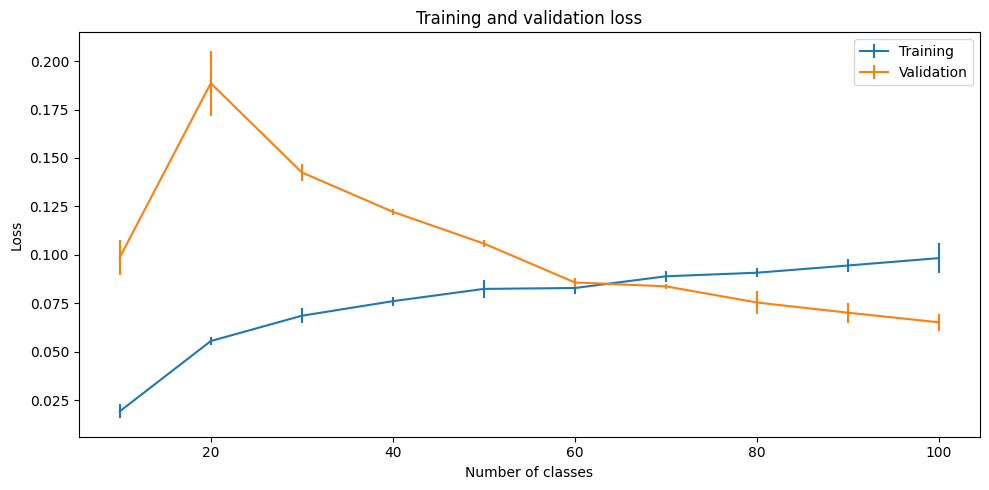

In [16]:
plot_train_val(train_loss_stats, val_loss_stats, loss = True)

#### Train validation accuracy

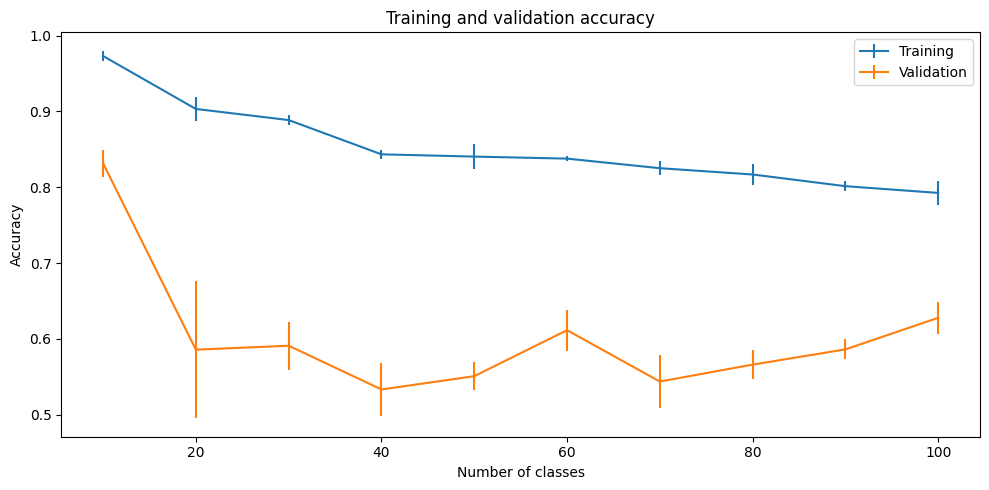

In [17]:
plot_train_val(train_accuracy_stats, val_accuracy_stats, loss = False)

#### Test accuracy

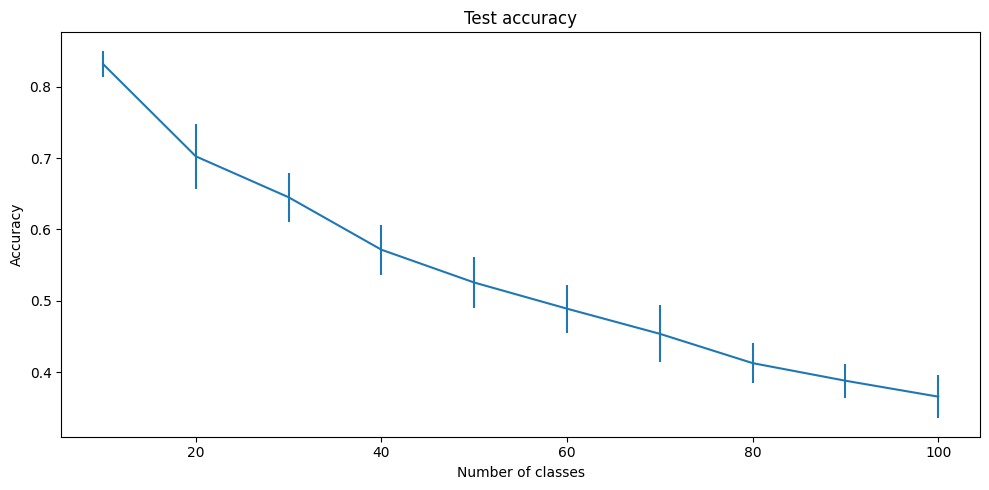

In [18]:
plot_test_accuracies(test_accuracy_stats)

#### Confusion Matrix

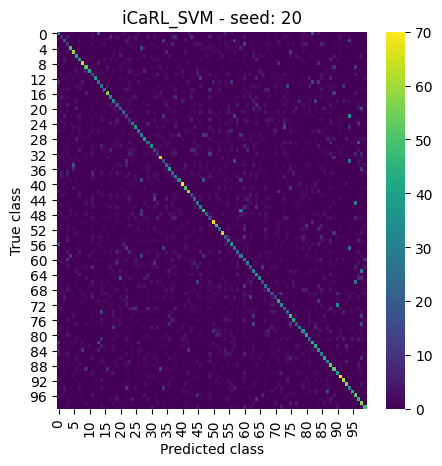

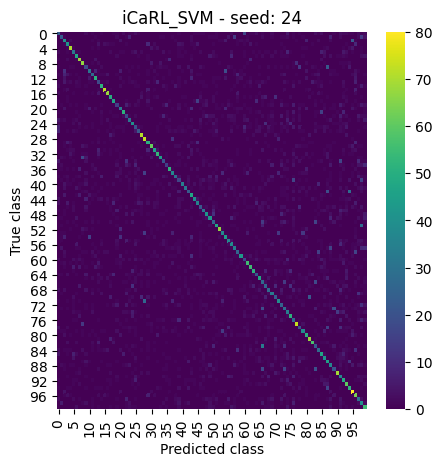

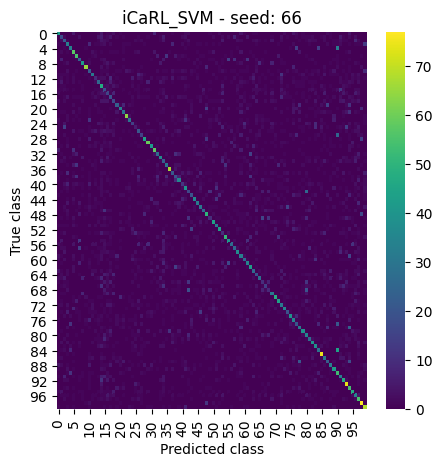

In [19]:
for run in range(len(RANDOM_SEED)):
  targets = np.array(true_labels[run])
  preds = np.array(predictions[run])

  plot_confusion_matrix(targets, preds, RANDOM_SEED[run], 'iCaRL_SVM')